In [43]:
import os
import sys
sys.path.append(os.path.join("..", ".."))
from scripts.data_loaders.common import show_hf_sample
from scripts.core.codes import ALL_ANNOTATED_IPA_SYMBOLS, string2symbols
from scripts.core.ipa import remove_length_diacritics, remove_tones_and_stress

from datasets import Dataset, load_dataset, concatenate_datasets, interleave_datasets

import torch

from transformers import (
    AutoModelForCTC,
    AutoFeatureExtractor,
    AutoTokenizer,
    AutoProcessor,
    Wav2Vec2CTCTokenizer,
    Wav2Vec2Processor
)

import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

from IPython.display import clear_output
clear_output()

In [12]:
PROJECT_NAME = "Facebook_Finetune_A"
PRE_TRAINED_ID = "facebook/wav2vec2-xlsr-53-phon-cv-ft"

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
) # used for sample inference, Trainer autodetects for training and eval
BATCH_SIZE = 32
NUM_PROC = max(1, os.cpu_count() - 1)  # type: ignore
RANDOM_SEED = 42  # KEEP CONST

TARGET_SAMPLE_RATE = 16_000

# Load Training Data

## Inspect Samples

### DoReCo

In [13]:
DoReCo_ds: Dataset = load_dataset("KoelLabs/DoReCo")["train"] # type: ignore
DoReCo_ds

Dataset({
    features: ['audio', 'ipa', 'text', 'id', 'speaker_code', 'speaker_age', 'speaker_gender', 'recording_year', 'recoding_topic', 'sound_quality', 'background_noise'],
    num_rows: 577
})

IPA: aɪwɒzfɔːwenaɪkʌmwiːkʌmtəwʌnkɒtɪdʒðəfɜːstmuːvfɹɒmsɪtɪŋbɔːn
Metadata: {'text': 'I was four when I come we come to one cottage the first move from Sittingbourne', 'id': 'T004', 'speaker_code': 'EN01', 'speaker_age': 85, 'speaker_gender': 'm', 'recording_year': 1975, 'recoding_topic': 'personal narrative', 'sound_quality': 'medium', 'background_noise': 'punctual'}


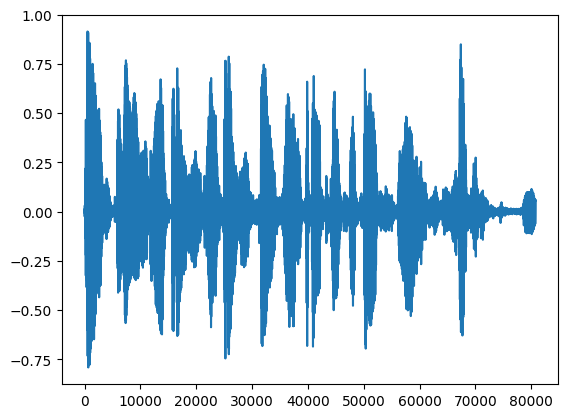

In [14]:
show_hf_sample(DoReCo_ds[0])

### EpaDB

In [15]:
EpaDB_ds: Dataset = load_dataset("KoelLabs/EpaDB")["train"] # type: ignore
EpaDB_ds

Dataset({
    features: ['audio', 'ipa', 'text', 'speaker_code'],
    num_rows: 1894
})

IPA: oɹnaɪsɹɛdtɔɪ
Metadata: {'text': ' our nice red toy ', 'speaker_code': 'spkr109'}


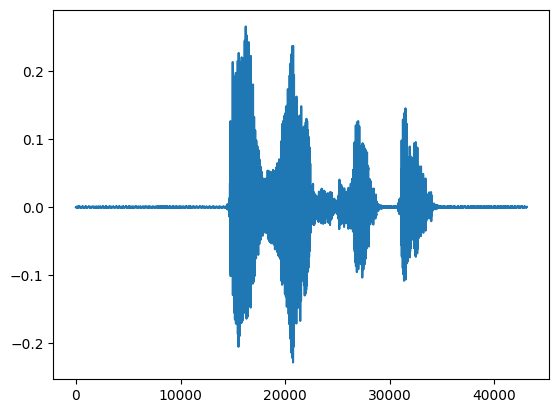

In [16]:
show_hf_sample(EpaDB_ds[0])

### L2Arctic

In [17]:
L2ArcticScripted_ds: Dataset = load_dataset("KoelLabs/L2Arctic")["scripted"] # type: ignore
L2ArcticScripted_ds

Dataset({
    features: ['audio', 'ipa', 'text', 'speaker_code', 'speaker_gender', 'speaker_native_language'],
    num_rows: 3599
})

IPA: fɔˈɹðʌˈtwɛˈntiɪθtaɪˈmðæˈtiˈvnɪŋkðʌˈtuˈmɛˈnʃʊˈkhæˈnss
Metadata: {'text': 'for the twentieth time that evening the two men shook hands', 'speaker_code': 'ABA', 'speaker_gender': 'm', 'speaker_native_language': 'Arabic'}


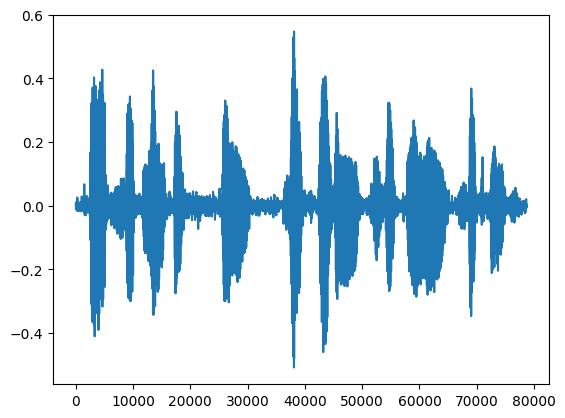

In [18]:
show_hf_sample(L2ArcticScripted_ds[0])

In [19]:
L2ArcticSpontaneous_ds: Dataset = load_dataset("KoelLabs/L2ArcticSpontaneousSplit")["train"] # type: ignore
L2ArcticSpontaneous_ds

Dataset({
    features: ['audio', 'ipa', 'speaker_code', 'speaker_gender', 'speaker_native_language'],
    num_rows: 129
})

IPA: jɛˈsʌˈmɪˈtsiˈmzɪffɹʌˈmðʌfɝˈsbɪˈktʃɝzzɪsɪzlaɪˈkʌbɪˈktʃɝoʊfʌˈmʌdaʊˈntaʊˈnɔfʌsiˈtiwɪˈzʌbɪˈkhɔtɛˈlsʌndtuˈtuˈbiˈpʌlwʌˈnwʊˈmʌnæˈndwʌˈnmæˈn
Metadata: {'speaker_code': 'aba', 'speaker_gender': 'm', 'speaker_native_language': 'Arabic'}


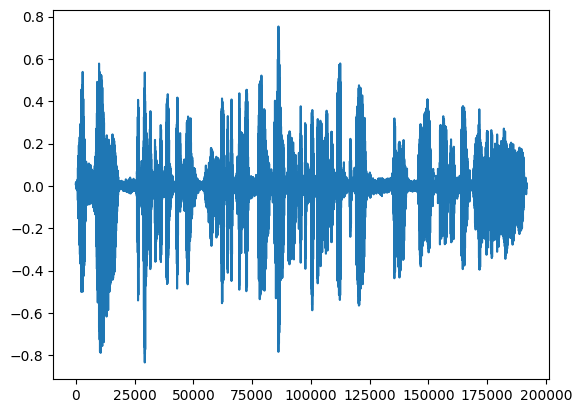

In [20]:
show_hf_sample(L2ArcticSpontaneous_ds[0])

### Buckeye

In [21]:
buckeye_ds: Dataset = load_dataset("KoelLabs/Buckeye")["train"] # type: ignore
buckeye_ds

Dataset({
    features: ['audio', 'ipa', 'speaker_code', 'speaker_gender', 'speaker_age', 'interviewer_gender'],
    num_rows: 3014
})

IPA: kaɪʌmaɪmaɪvlʌvdɪnklʌbʌsmaɪɛntɛɹlaɪfθɚɾifoʊjɛɹsʌmboʊɹɛ̃nɹeɪzdʌnnʌwɛssaɪʌfklʌmbɛsʌmʌmaɪmeɪʌmɪskʌɾ̃ʌveɪjɪnikpʌzʌʃʌnaɪaɪɡɛsʌmeɪʌmmaɪdʒɑbtaɪɾl̩ʌzʊsinjɚɹisɚtʃʊsoʊsiɛʔʌmaɪɹisivdmaɪʌmbæʃlɚsmæstɚspieɪtʃdiɪnnɚspɹʌktɪʃnʌɑfɹʌmhiɹfɹʌmoʊɛʃju
Metadata: {'speaker_code': 's01', 'speaker_gender': 'f', 'speaker_age': 'young', 'interviewer_gender': 'female'}


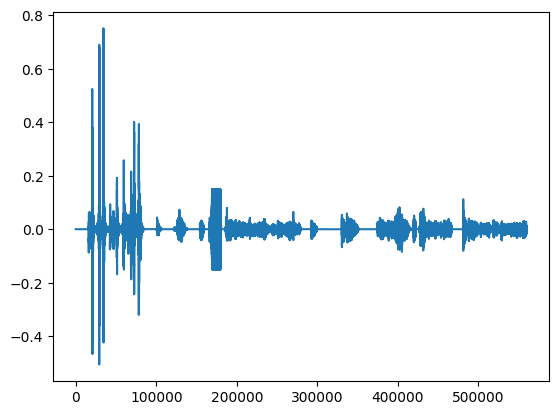

In [22]:
show_hf_sample(buckeye_ds[0])

### PSST

In [23]:
psst_ds: Dataset = load_dataset("KoelLabs/PSST")["train"] # type: ignore
psst_ds

Dataset({
    features: ['audio', 'ipa', 'utterance_id', 'utterance_text_prompt', 'recording_test', 'recording_session', 'pronunciation_is_correct', 'speaker_aq_index'],
    num_rows: 2298
})

IPA: haʊs
Metadata: {'utterance_id': 'ACWT02a-BNT01-house', 'utterance_text_prompt': 'house', 'recording_test': 'BNT', 'recording_session': 'ACWT02a', 'pronunciation_is_correct': True, 'speaker_aq_index': 74.6}


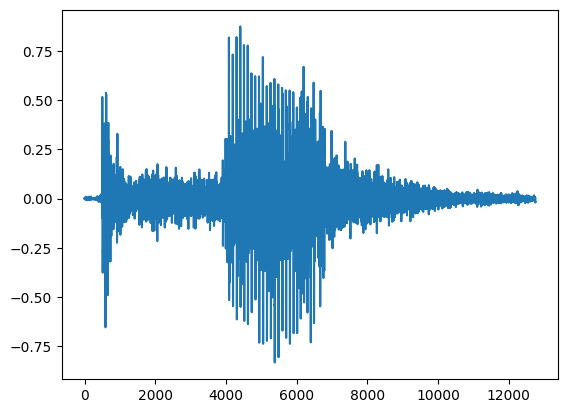

In [24]:
show_hf_sample(psst_ds[0])

### Speech Ocean

In [25]:
speechocean_ds: Dataset = load_dataset("KoelLabs/SpeechOceanNoTH")["train"] # type: ignore
speechocean_ds

Dataset({
    features: ['audio', 'ipa', 'text', 'speaker_code', 'speaker_gender', 'speaker_age', 'pronunciation_accuracy_0_to_10', 'pronunciation_completeness_fraction', 'pauseless_flow_0_to_10', 'cadence_and_intonation_0_to_10'],
    num_rows: 1120
})

IPA: wikɔlɪtbɛɹ
Metadata: {'text': 'WE CALL IT BEAR', 'speaker_code': '0001', 'speaker_gender': 'm', 'speaker_age': 6, 'pronunciation_accuracy_0_to_10': 8, 'pronunciation_completeness_fraction': 10.0, 'pauseless_flow_0_to_10': 9, 'cadence_and_intonation_0_to_10': 9}


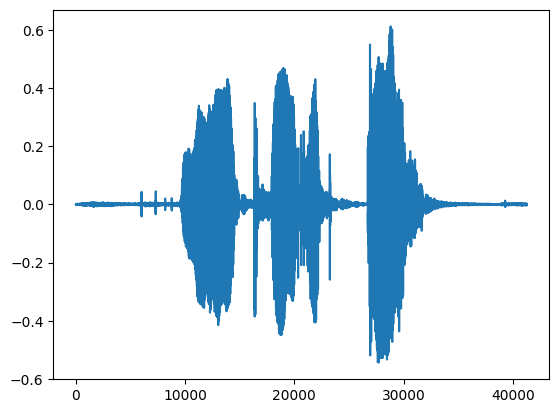

In [26]:
show_hf_sample(speechocean_ds[0])

### TIMIT

In [27]:
timit_ds: Dataset = load_dataset("KoelLabs/TIMIT")["train"] # type: ignore
timit_ds

Dataset({
    features: ['audio', 'ipa', 'text', 'speaker_code', 'speaker_gender', 'speaker_dialect', 'speaker_birth_date', 'speaker_height', 'speaker_ethnicity', 'speaker_education', 'recording_date'],
    num_rows: 4620
})

IPA: doʊɾ̃æskmitɨkɛɹɪɨnʔɔɪliɹæɡlaɪkðæʔ
Metadata: {'text': 'Dont ask me to carry an oily rag like that', 'speaker_code': 'REM0', 'speaker_gender': 'M', 'speaker_dialect': 'Western', 'speaker_birth_date': '10/05/34', 'speaker_height': '6\'2"', 'speaker_ethnicity': ' WHT', 'speaker_education': 'BS', 'recording_date': '04/02/86'}


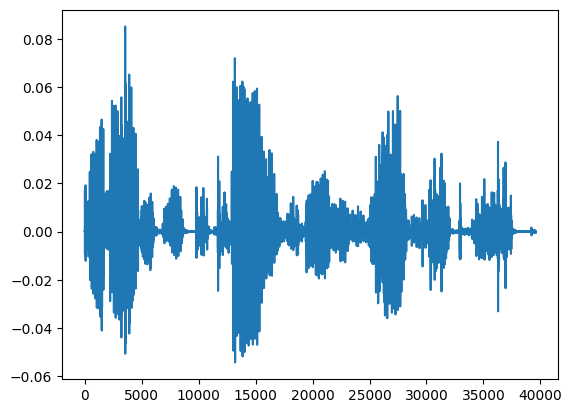

In [28]:
show_hf_sample(timit_ds[0])

## Combine Datasets

In [29]:
datasets = [
    DoReCo_ds,
    EpaDB_ds,
    L2ArcticScripted_ds,
    L2ArcticSpontaneous_ds,
    buckeye_ds,
    psst_ds,
    speechocean_ds,
    timit_ds,
]

In [30]:
# only keep the columns we need
columns = ["ipa", "audio"]
datasets = list(map(lambda x: x.remove_columns([col for col in x.column_names if col not in columns]), datasets))

In [31]:
# just concatenate one by one for now
combined_ds = concatenate_datasets(datasets)
# alternatively, sample randomly according to quality:
# probabilities = [0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.2]
# combined_ds = interleave_datasets(datasets, probabilities=probabilities, seed=RANDOM_SEED, stopping_strategy="all_exhausted")

## Check Distributions

In [32]:
audio_lengths = []
ipa_lengths = []
labels = []

for ds in datasets:
    # Calculate audio durations
    durations = [x["audio"]["array"].shape[0] / x["audio"]["sampling_rate"] for x in ds] # type: ignore
    audio_lengths.append(durations)
    # Calculate IPA string lengths
    ipa_len = [len(x["ipa"]) for x in ds]  # type: ignore
    ipa_lengths.append(ipa_len)
    labels.append(ds.info.dataset_name)

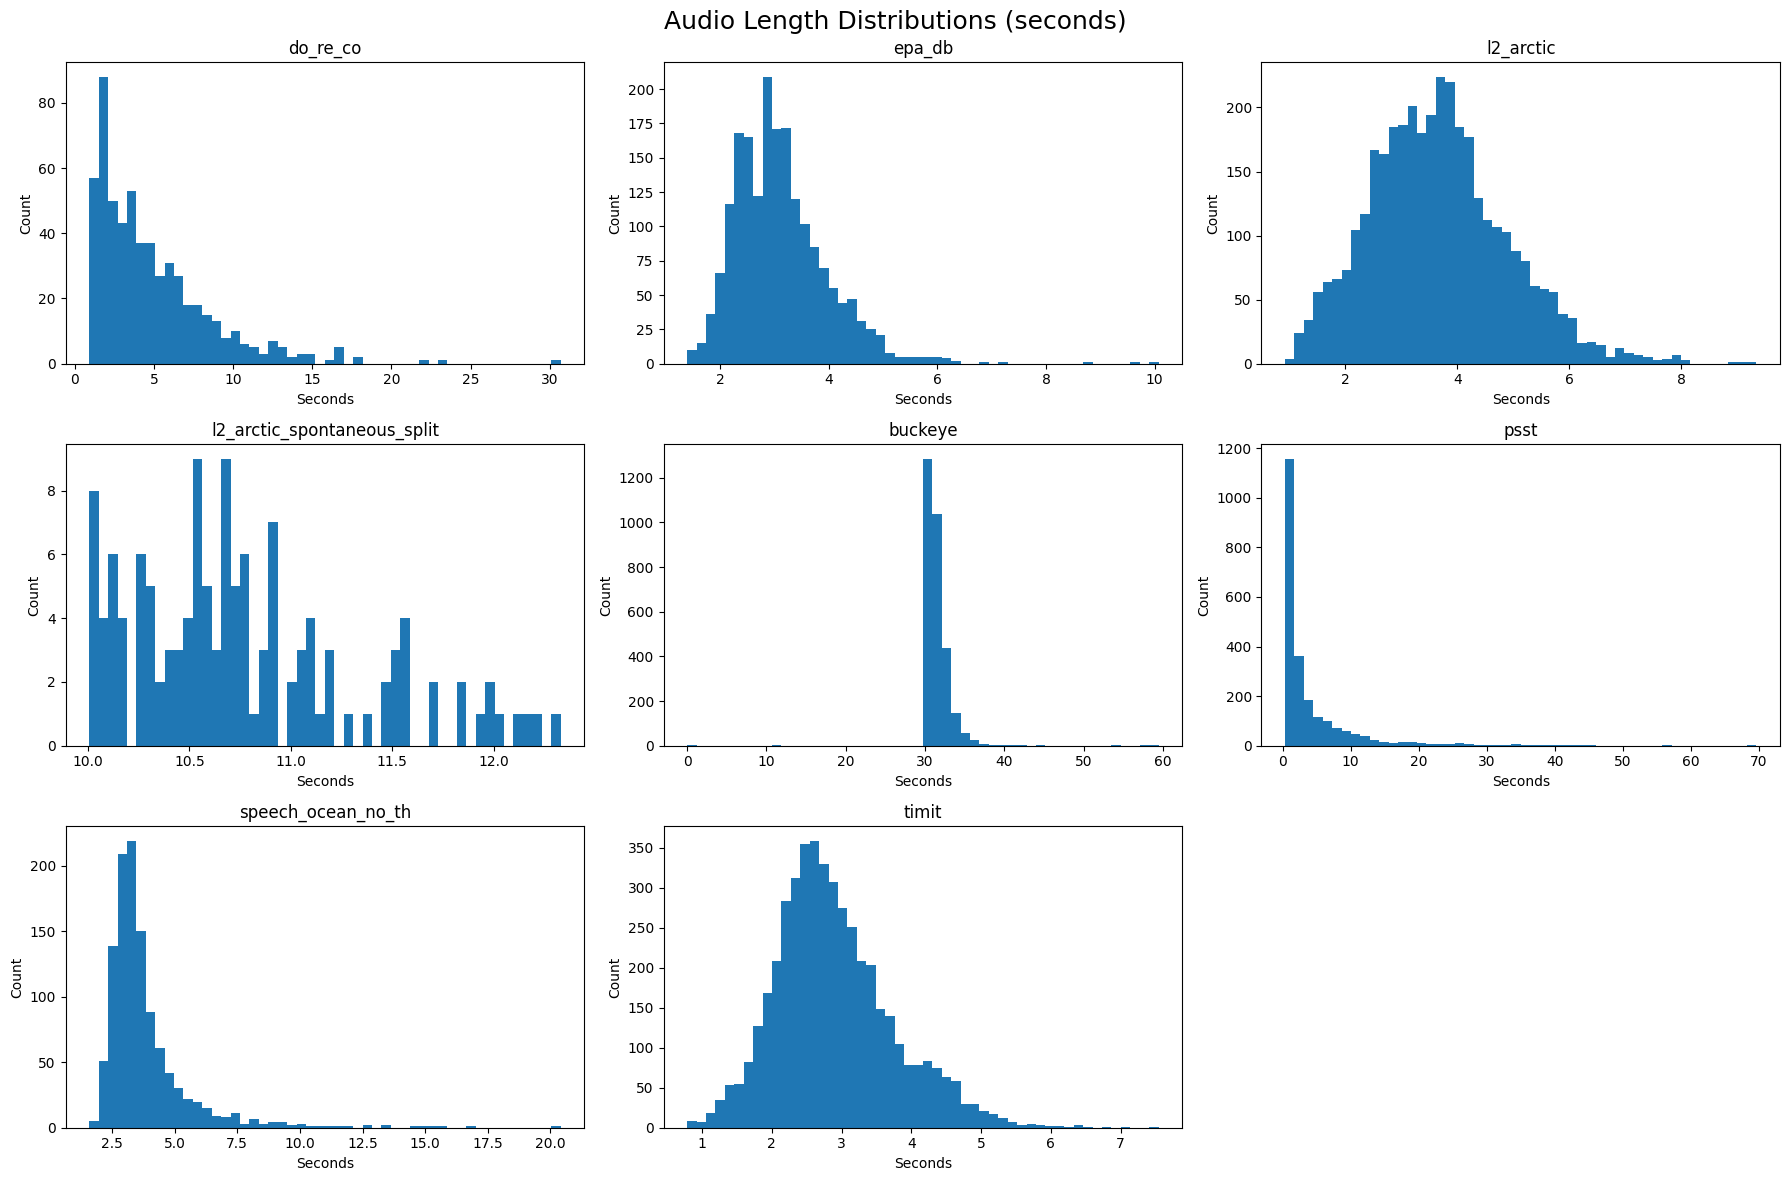

In [33]:
ncols = 3  # Number of columns per row
nrows = int(np.ceil(len(datasets) / ncols))

# Audio Lengths Plot
fig1, axs1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
fig1.suptitle('Audio Length Distributions (seconds)', fontsize=18)
axs1 = axs1.flatten()  # Make indexing easy
for idx, (lengths, label) in enumerate(zip(audio_lengths, labels)):
    axs1[idx].hist(lengths, bins=50)
    axs1[idx].set_title(f'{label}')
    axs1[idx].set_xlabel('Seconds')
    axs1[idx].set_ylabel('Count')
# Hide any unused subplots
for j in range(idx+1, len(axs1)):
    fig1.delaxes(axs1[j])
fig1.tight_layout()
plt.show()

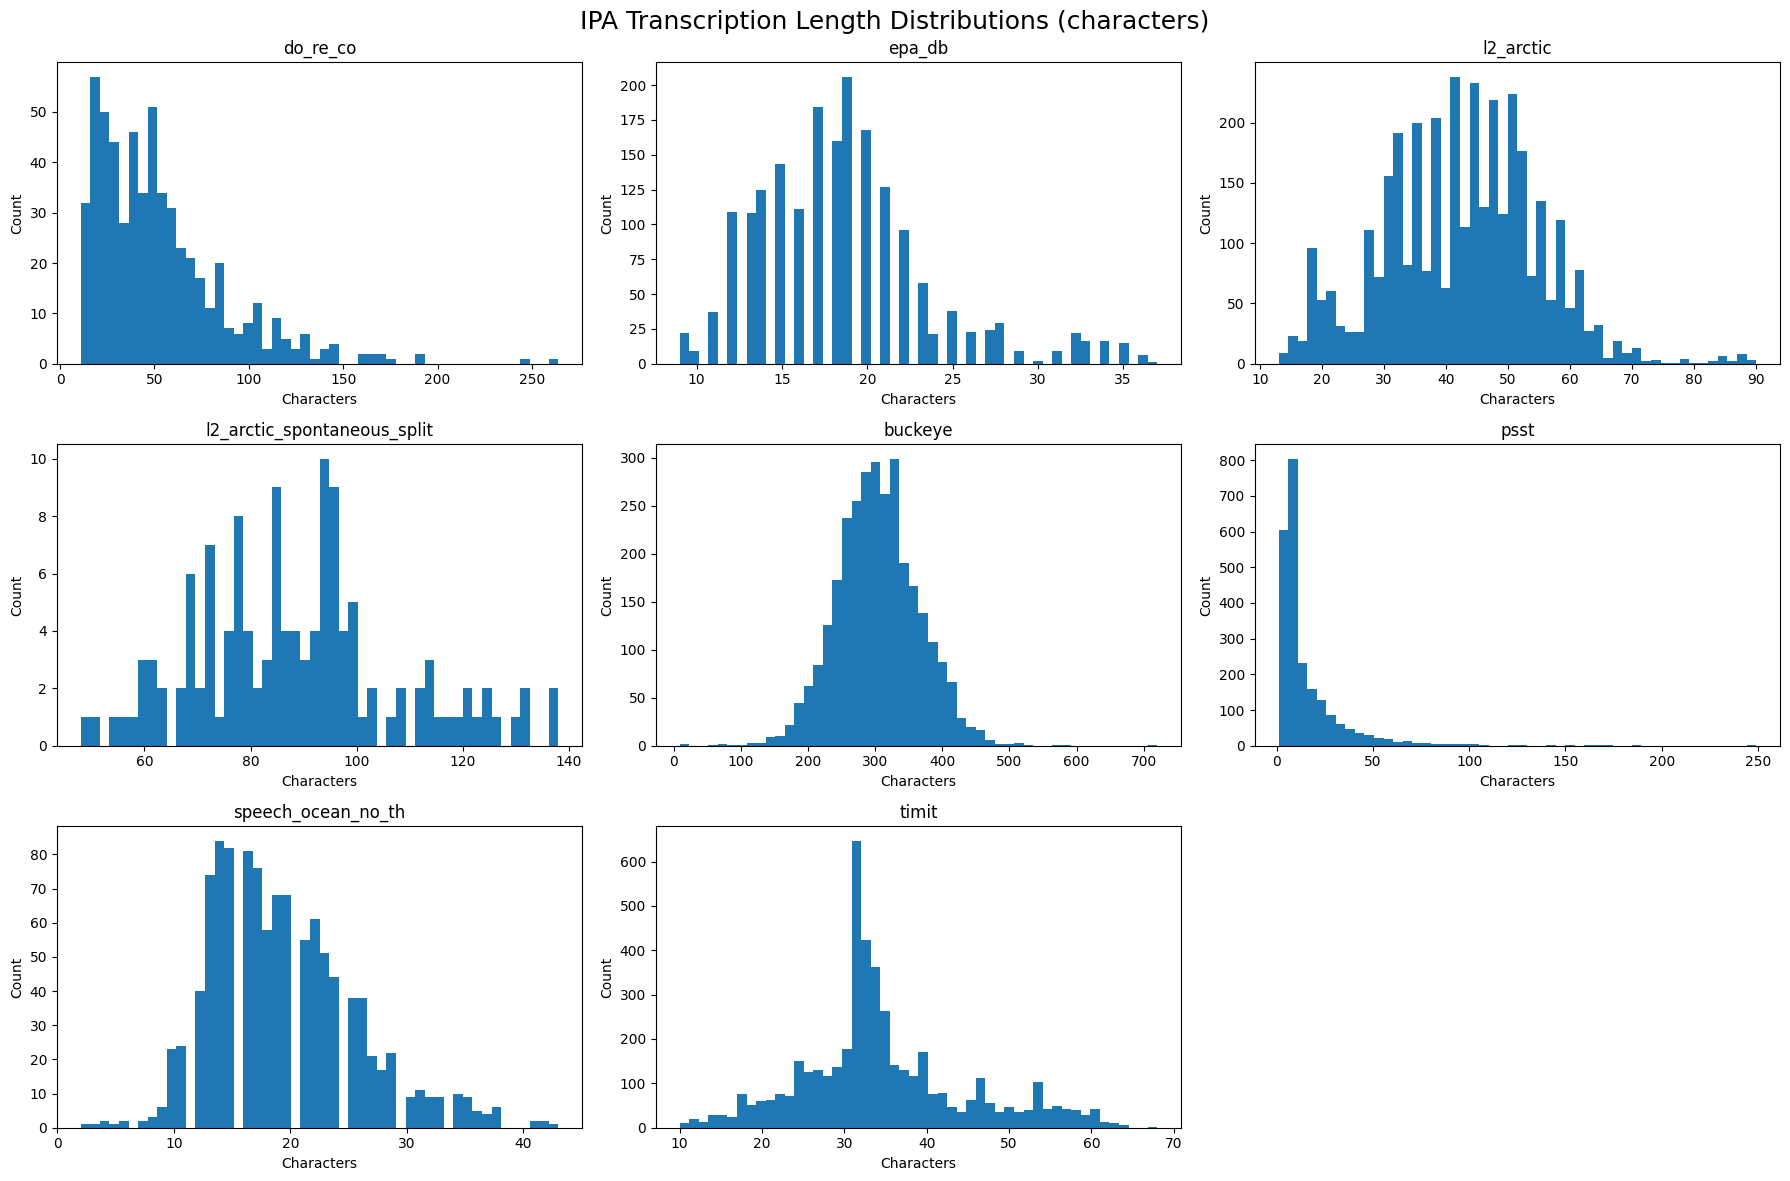

In [34]:
# IPA Lengths Plot
fig2, axs2 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
fig2.suptitle('IPA Transcription Length Distributions (characters)', fontsize=18)
axs2 = axs2.flatten()
for idx, (lengths, label) in enumerate(zip(ipa_lengths, labels)):
    axs2[idx].hist(lengths, bins=50)
    axs2[idx].set_title(f'{label}')
    axs2[idx].set_xlabel('Characters')
    axs2[idx].set_ylabel('Count')
for j in range(idx+1, len(axs2)):
    fig2.delaxes(axs2[j])
fig2.tight_layout()
plt.show()

In [ ]:
for lengths, label in zip(audio_lengths, labels):
    print(label, "speech minutes: ", sum(lengths) / 60)

do_re_co speech hours:  47.243632291666685
epa_db speech hours:  98.3884937499998
l2_arctic speech hours:  219.80634583333324
l2_arctic_spontaneous_split speech hours:  23.14519687500001
buckeye speech hours:  1580.6956520833367
psst speech hours:  166.36047187499915
speech_ocean_no_th speech hours:  71.56938333333342
timit speech hours:  222.97526145833316


In [35]:
print("Total audio hours:", sum(s for s in (sum(a) for a in audio_lengths)) / 60 / 60)

Total audio hours: 40.50307395833337


# Load Model and Update Vocabulary

In [132]:
# Identify a set of symbols that covers the dataset, use the same groupings as the annotators so we don't make up ones that don't exist
symbol_uses = {k: [] for k in ALL_ANNOTATED_IPA_SYMBOLS} # type: ignore

def uses_only_symbols(string):
    return string in ALL_ANNOTATED_IPA_SYMBOLS or all(string2symbols(string, ALL_ANNOTATED_IPA_SYMBOLS)[1]) # type: ignore

def reduce_uses(ipa, idx):
    ipa = remove_length_diacritics(remove_tones_and_stress(ipa.replace(" ", "")))
    assert uses_only_symbols(ipa), f"Dataset contains unaccounted for symbols: {ipa}"
    for symbol in symbol_uses.keys():
        if symbol in ipa:
            symbol_uses[symbol].append(idx)

combined_ds.map(reduce_uses, input_columns="ipa", with_indices=True)

dataset_vocab = set(k for k, v in symbol_uses.items() if len(v) > 0 and k)
print(dataset_vocab)

Map:   0%|          | 0/17251 [00:00<?, ? examples/s]

{'ɛ', 'aɪ̃', 'ɣ', 'æ', 'ɾ', 'n', 'ɛ̃', 'u', 'ɜ', 'æ̃', 'ĩ', 'ɒ', 'ŋ̍', 'ʒ', 'oʊ̃', 'l̩', 'β', 'ʉ', 'ɔɪ', 'm̩', 'r', 'i', 'ʊ̃', 's', 'ʌ', 'f', 'v', 'ʃ', 't', 'h', 'ɪ', 'ɹ', 'o', 'ɚ', 'oʊ', 'θʰ', 'ĩ', 'aʊ', 'ð', 'e', 'ɡ', 'kʰ', 'ʔ', 'ɨ', 'ə̥', 'd', 'pʰ', 'j', 'ŋ', 'sʰ', 'ɔ', 'ɑ', 'ʊ', 'eɪ', 'ɑ̃', 'n̩', 'a', 'ə', 'm', 'z', 'ɝ', 'dʒ', 'θ', 'k', 'ɦ', 'ə̃', 'tʃ', 'l', 'aɪ', 'ɾ̃', 'w', 'p', 'x', 'b'}


IPA: ɛɾoʊ̃θɪŋkkɪdshævðɪsɛɾ̃ɚbeɪstʌðʌfæmlɪɪtðeɪjustʌhævɛndʌɾoʊnoʊðʌðɪkʌltʃɚɪsdʒɪssoʊfæspeɪsðætæɾoʊnθɪŋpipl̩ɚmeɪbiɪtsnɑɾɑɾ̃ɪstimeɪbiɪtsdʒʌsðɛɾoʊnhævæsmʌtʃtaɪmɪɡɪɛtætʃtændðɛɹɹɛɾiʌmuvɑɾ̃ʌɡɛnjudʒɪsdoʊ̃ɡɪtɪskloʊstpipl̩ʌzjijustʃujæɹaɪtɹaɪtaɪkn̩ɑɹɡjuboʊθsaɪdsʌðætaɪmæɾʌlʌɡʃɚɪaɪɡɛswɛɹwɚæɾɛpɪsɪʃʌnwɛɹ
Metadata: {}


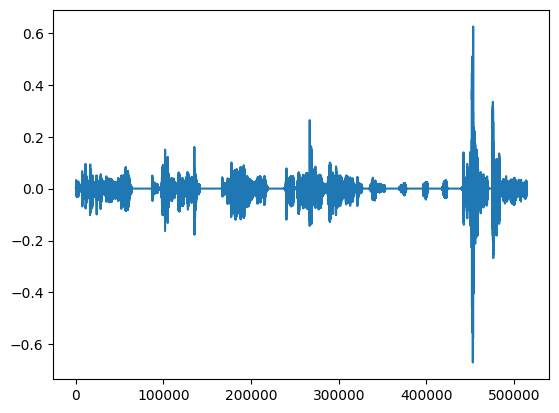

In [134]:
# Inspect some samples with interesting symbols
sample = combined_ds[symbol_uses['oʊ̃'][7]]
show_hf_sample(sample)

In [135]:
# Determine the set of symbols supported by the pretrained model
old_tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
model_vocab = old_tokenizer.get_vocab()
print(model_vocab)

{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 't': 5, 's': 6, 'a': 7, 'ɪ': 8, 'l': 9, 'ə': 10, 'd': 11, 'ɛ': 12, 'e': 13, 'k': 14, 'i': 15, 'm': 16, 'o': 17, 'p': 18, 'z': 19, 'ʁ': 20, 'b': 21, 'v': 22, 'f': 23, 'j': 24, 'r': 25, 'ɻ': 26, 'u': 27, 'w': 28, 'ɔ': 29, 'æ': 30, 'ʊ': 31, 'ɒ': 32, 'iː': 33, 'ɾ': 34, 'ʃ': 35, 'h': 36, 'θ': 37, 'eɪ': 38, 'ŋ': 39, 'y': 40, 'ð': 41, 'R': 42, 'ɡ': 43, 'ɜ': 44, 'g': 45, 'uː': 46, 'ɔː': 47, 'aɪ': 48, 'ʌ': 49, 'x': 50, 'aː': 51, 'əʊ': 52, 'ɑː': 53, 'ɜː': 54, 'n̩': 55, 'ɑ': 56, 'eː': 57, 'ɲ': 58, 'ʒ': 59, 'dʒ': 60, 'l̩': 61, 'ɑ̃': 62, 'ai': 63, 'ts': 64, 'β': 65, 'œ': 66, 'oː': 67, 'aʊ': 68, 'ɔ̃': 69, 'ʏ': 70, 'ɪə': 71, 'ɛə': 72, 'ɥ': 73, 'ʂ': 74, 'ɕ': 75, 'au': 76, 'ɨ': 77, 'c': 78, 'ɯ': 79, 'ɫ': 80, 'ʔ': 81, '’': 82, 'ɛ̃': 83, 'ʈʂ': 84, 'tɕ': 85, 'ø': 86, 'lʲ': 87, 'ʎ': 88, 'ʊə': 89, 'tʲ': 90, 'rʲ': 91, 'ɔɪ': 92, 'nʲ': 93, 'sʲ': 94, 'tʰ': 95, 'ʕ': 96, 'tɕʰ': 97, 'ʈʂʰ': 98, 'ɣ': 99, 'ɔy': 100, 'dʲ': 101, 'kʰ': 102, 'q': 103, 'ʐ': 104, 'ɹ': 1

In [136]:
# Reconcile model vocab with dataset vocab:
#   - Pair each dataset token with corresponding token ids in model_vocab
#   - If there is an exact match, we go by that, otherwise, we break down by part
#   - We will average weights if multiple matches, otherwise just transfer them, unmatched tokens will get randomly initialized

def flatten_list(nested_list):
    flattened = []
    for item in nested_list:
        if isinstance(item, list):
            flattened.extend(flatten_list(item))  # Recursively flatten sublists
        else:
            flattened.append(item)
    return flattened

unmatched = set(['<s>', '<pad>', '</s>', '<unk>']) | dataset_vocab.copy()

special_tokens = {"<pad>": 0, "<s>": 1, "</s>": 2, "<unk>": 3}
unmatched -= set(special_tokens.keys())

matched_tokens = {}
for s in unmatched:
    if s in model_vocab:
        matched_tokens[s] = model_vocab[s]
unmatched -= set(matched_tokens.keys())

partial_matched_tokens = {}
weird_symbols = {
    '̥': [v for k, v in model_vocab.items() if '̥' in k],
    '̃': [v for k, v in model_vocab.items() if '̃' in k],
    '̍': [v for k, v in model_vocab.items() if '̍' in k],
}
combined_model_vocab = model_vocab.copy() | weird_symbols
for s in unmatched:
    if s == 'ĩ' or s == 'ĩ': # edge case, this one doesn't split properly when looping through characters
        parts = ['ɪ', '̃'] if s == 'ĩ' else ['i', '̃']
        matched = [p in combined_model_vocab.keys() for p in parts]
    else:
        parts, matched = string2symbols(s, combined_model_vocab.keys())
    if all(matched):
        partial_matched_tokens[s] = flatten_list([combined_model_vocab[p] for p in parts])
unmatched -= set(partial_matched_tokens.keys())

print('Matched', matched_tokens)
print('Partial Matched', partial_matched_tokens)
print('Unmatched', unmatched)

# Old Aruna results for comparison:
# specials = ["<pad>", "<s>", "</s>", "<unk>"]
# matched_vocab = {"a", "ʒ", "ɨ", "ɡ", "d", "ɦ", "ɛ", "ɾ", "o", "θ", "æ", "ŋ", "u", "ɝ", "p", "ɒ", "ə", "ɔ", "ʔ", "t", "v", "x", "ɹ", "β", "i", "s", "f", "m", "z", "ʌ", "ʊ", "l", "n", "h", "ɪ", "ɚ", "ɑ", "e", "w", "k", "ʉ", "b", "ɜ", "ð", "j", "ʃ", "r", "aʊ", "dʒ", "dz", "l̩", "pʰ", "ɛ̃", "m̩", "æ̃", "aɪ", "eɪ", "ɑ̃", "ɔɪ", "kʰ", "ts", "n̩", "tʃ", "ʊ̃"} # fmt: skip
# partial_unmatched = {
#     "ŋ̍": [263, 39],
#     "oʊ̃": [225, 17, 31],
#     "ɡɣ": [43, 99],
#     "ə̃": [10, 129],
#     "sʰ": [6, 220],
#     "aɪ̃": [7, 8, 48],
#     "oʊ": [31, 17],
#     "θʰ": [37, 220],
#     "ə̥": [10, 36],
# }
# full_unmatched = {
#     "ʍ": 28,  # maps to token w
#     "ʟ": 80,  # maps to token ɫ
#     "ĩ": 15,
#     "ɾ̃": 34,  # maps to token ɾ
# }

Matched {'ɣ': 99, 'æ': 30, 'ɾ': 34, 'n': 4, 'ɛ̃': 83, 'u': 27, 'ɜ': 44, 'æ̃': 222, 'ʒ': 59, 'l̩': 61, 'β': 65, 'ʉ': 132, 'ɔɪ': 92, 'r': 25, 'ʊ̃': 225, 's': 6, 'ʌ': 49, 'f': 23, 'v': 22, 't': 5, 'h': 36, 'ɹ': 105, 'o': 17, 'aʊ': 68, 'ʔ': 81, 'pʰ': 118, 'ŋ': 39, 'ʊ': 31, 'eɪ': 38, 'ɑ̃': 62, 'n̩': 55, 'm': 16, 'z': 19, 'k': 14, 'ɦ': 119, 'x': 50, 'ɛ': 12, 'ɒ': 32, 'm̩': 248, 'i': 15, 'ʃ': 35, 'ɪ': 8, 'ɚ': 125, 'ð': 41, 'e': 13, 'ɡ': 43, 'kʰ': 102, 'ɨ': 77, 'd': 11, 'j': 24, 'ɔ': 29, 'ɑ': 56, 'a': 7, 'ə': 10, 'θ': 37, 'ɝ': 108, 'dʒ': 60, 'tʃ': 111, 'l': 9, 'aɪ': 48, 'w': 28, 'p': 18, 'b': 21}
Partial Matched {'aɪ̃': [48, 62, 69, 83, 129, 147, 160, 168, 171, 182, 196, 222, 224, 225, 227, 245], 'ə̥': [10], 'ĩ': [15, 62, 69, 83, 129, 147, 160, 168, 171, 182, 196, 222, 224, 225, 227, 245], 'ŋ̍': [39], 'sʰ': [6, 220], 'oʊ̃': [17, 225], 'ĩ': [8, 62, 69, 83, 129, 147, 160, 168, 171, 182, 196, 222, 224, 225, 227, 245], 'ə̃': [10, 62, 69, 83, 129, 147, 160, 168, 171, 182, 196, 222, 224, 225, 227, 

In [137]:
# Renumber the token sequence
token_to_old_id = special_tokens | matched_tokens | partial_matched_tokens
token_sequence = sorted(token_to_old_id.keys(), key=lambda x: token_to_old_id[x][0] if isinstance(token_to_old_id[x], list) else token_to_old_id[x]) # type: ignore
vocab_dict = {tok: idx for idx, tok in enumerate(token_sequence)}
print(vocab_dict)

{'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, 'n': 4, 't': 5, 's': 6, 'sʰ': 7, 'a': 8, 'ɪ': 9, 'ĩ': 10, 'l': 11, 'ə': 12, 'ə̥': 13, 'ə̃': 14, 'd': 15, 'ɛ': 16, 'e': 17, 'k': 18, 'i': 19, 'ĩ': 20, 'm': 21, 'o': 22, 'oʊ̃': 23, 'oʊ': 24, 'p': 25, 'z': 26, 'b': 27, 'v': 28, 'f': 29, 'j': 30, 'r': 31, 'u': 32, 'w': 33, 'ɔ': 34, 'æ': 35, 'ʊ': 36, 'ɒ': 37, 'ɾ': 38, 'ɾ̃': 39, 'ʃ': 40, 'h': 41, 'θ': 42, 'θʰ': 43, 'eɪ': 44, 'ŋ': 45, 'ŋ̍': 46, 'ð': 47, 'ɡ': 48, 'ɜ': 49, 'aɪ': 50, 'aɪ̃': 51, 'ʌ': 52, 'x': 53, 'n̩': 54, 'ɑ': 55, 'ʒ': 56, 'dʒ': 57, 'l̩': 58, 'ɑ̃': 59, 'β': 60, 'aʊ': 61, 'ɨ': 62, 'ʔ': 63, 'ɛ̃': 64, 'ɔɪ': 65, 'ɣ': 66, 'kʰ': 67, 'ɹ': 68, 'ɝ': 69, 'tʃ': 70, 'pʰ': 71, 'ɦ': 72, 'ɚ': 73, 'ʉ': 74, 'æ̃': 75, 'ʊ̃': 76, 'm̩': 77}


In [138]:
# Save updated tokenizer
SAVE_DIR = os.path.join("..", "..", "models", "facebook53_condensed")
os.makedirs(SAVE_DIR, exist_ok=True)

VOCAB_JSON = os.path.join(SAVE_DIR, 'vocab.json')
with open(VOCAB_JSON, 'w') as f:
    f.write(json.dumps(vocab_dict, ensure_ascii=False, indent=2))

tokenizer = Wav2Vec2CTCTokenizer(
    VOCAB_JSON, pad_token="<pad>", unk_token="<unk>", bos_token='<s>', eos_token='</s>'
)
tokenizer.save_pretrained(SAVE_DIR)

('../../models/facebook53_condensed/tokenizer_config.json',
 '../../models/facebook53_condensed/special_tokens_map.json',
 '../../models/facebook53_condensed/vocab.json',
 '../../models/facebook53_condensed/added_tokens.json')

In [139]:
# Transfer model weights

# load old weights
model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)
old_W = model.lm_head.weight.data.clone()
old_b = model.lm_head.bias.data.clone()

# shrink lm_head & update vocab_size
in_feats = model.lm_head.in_features
model.lm_head = torch.nn.Linear(in_feats, len(vocab_dict), bias=True)
model.config.vocab_size = len(vocab_dict)
torch.nn.init.normal_(model.lm_head.weight, std=0.02)

# set new weights
new_W, new_B = model.lm_head.weight.data, model.lm_head.bias.data
rng = torch.Generator().manual_seed(RANDOM_SEED)
jitter = lambda v, s=0.01: v + torch.empty_like(v).uniform_(-s, s, generator=rng)

# copy / average / jitter weights
for tok, new_id in vocab_dict.items():
    old_ids = token_to_old_id[tok]

    if isinstance(old_ids, int):
        # single perfect match - copy weights
        new_W[new_id] = old_W[old_ids]
        new_B[new_id] = old_b[old_ids]
    else:
        if len(old_ids) == 1:
            # single imperfect match - jitter
            new_W[new_id] = jitter(old_W[old_ids[0]])
            new_B[new_id] = old_b[old_ids[0]]
        else:
            # multiple matches - average
            weights = [0.5] + [0.5 / (len(old_ids) - 1) for _ in range(len(old_ids) - 1)]
            new_W[new_id] = torch.stack([old_W[i] * w for i, w in zip(old_ids, weights)]).mean(0)
            new_B[new_id] = torch.stack([old_b[i] * w for i, w in zip(old_ids, weights)]).mean(0)

In [140]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)
Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer).save_pretrained(
    SAVE_DIR
)

print(" transfer complete")
print(f"   old head rows : {old_W.size(0)}")
print(f"   new head rows : {new_W.size(0)}")
print(f"   max old2id    : {max(model_vocab.values())}")
print(f"   max vocab id  : {max(vocab_dict.values())}\n")

model.save_pretrained(SAVE_DIR)
print("🚀  Condensed checkpoint saved to", SAVE_DIR)

 transfer complete
   old head rows : 272
   new head rows : 78
   max old2id    : 271
   max vocab id  : 77

🚀  Condensed checkpoint saved to ../../models/facebook53_condensed


In [141]:
def prepare_model_and_processor(freeze_feature_extractor=True):
    processor = AutoProcessor.from_pretrained(SAVE_DIR)
    model = AutoModelForCTC.from_pretrained(SAVE_DIR)

    # Freeze the CNN encoder
    if freeze_feature_extractor:
        for p in model.wav2vec2.feature_extractor.parameters():
            p.requires_grad = False

    return model, processor

# Preprocess Data

In [122]:
_, processor = prepare_model_and_processor()

In [119]:
def is_not_empty(row):
    return (
        row.get('audio') is not None
        and row.get('ipa') is not None
        and len(row['ipa']) > 0
        and row['audio'].get('array') is not None
        and len(row['audio']['array']) > 0
    )

def process_row(row):
    # model expects audio to be float32 @ 16 kHz
    assert row['audio']['sampling_rate'] == TARGET_SAMPLE_RATE
    audio = row['audio']['array'].astype(np.float32, copy=False)
    inputs = processor(
        audio, sampling_rate=TARGET_SAMPLE_RATE, return_tensors=None
    )
    input_values = np.asarray(inputs["input_values"][0], dtype=np.float32)
    labels = processor(text=row["ipa"]).input_ids
    return {
        "input_values": input_values,
        "labels": labels,
    }

In [120]:
processed_ds = combined_ds.filter(is_not_empty, num_proc=NUM_PROC, batched=False)
processed_ds = processed_ds.map(process_row, num_proc=NUM_PROC, batched=False)

Filter (num_proc=9):   0%|          | 0/17251 [00:00<?, ? examples/s]

Map (num_proc=9):   0%|          | 0/17250 [00:00<?, ? examples/s]

In [ ]:
def prepare_datasets():
    split_dataset = processed_ds.train_test_split(test_size=0.2, seed=RANDOM_SEED)
    train_ds = split_dataset['train'].set_format(type='torch')
    val_ds = split_dataset['test'].set_format(type='torch')
    return train_ds, val_ds

In [125]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Dynamically pad *both* the acoustic inputs and the target
    label sequences for CTC training.

    Notes
    -----
    • Speech features are padded with 0.0 (default supplied by
      `Wav2Vec2Processor.pad`).
    • Label padding indices are replaced with **–100**, so that
      `nn.CTCLoss` ignores them.
    """

    processor: Wav2Vec2Processor
    padding: "bool | str" = True  # "longest" | "max_length" | True
    pad_to_multiple_of: "int | None" = None  # e.g. 8 for tensor cores

    def __call__(self, features: list[dict[str, torch.Tensor]]) -> dict[str, torch.Tensor]:
        # ─── 1) separate source and target sequences ──────────────────────────────
        input_values = [f["input_values"] for f in features]
        labels = [f["labels"] for f in features]

        # ─── 2) pad acoustic inputs ──────────────────────────────────────────────
        acoustic_batch = self.processor.pad(
            {"input_values": input_values},
            padding=self.padding,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # ─── 3) pad label sequences (using target processor branch) ──────────────
        with self.processor.as_target_processor():
            label_batch = self.processor.pad(
                {"input_ids": labels},
                padding=self.padding,
                pad_to_multiple_of=self.pad_to_multiple_of,
                return_tensors="pt",
            )

        # ─── 4) replace label padding with -100 so CTCLoss ignores it ────────────
        labels_padded = label_batch["input_ids"]
        padding_mask = label_batch["attention_mask"].ne(1)  # 1 ↔ real token
        labels_padded[padding_mask] = -100

        # ─── 5) assemble final batch ─────────────────────────────────────────────
        acoustic_batch["labels"] = labels_padded
        return acoustic_batch

In [ ]:
# Rest of TIMIT_Finetune_Facebook53.ipynb goes here